In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scratchers.attn import Attention, MultiheadAttention
from scratchers.transformer import TransformerBlock, TransformerDecoder, Config

# Data generation

In [2]:
SOURCE_SEQ_LEN = 6
TARGET_SEQ_LEN = 6

DATA_SIZE = 1200
TRAIN_SIZE = int(1200 * 0.8)
TEST_SIZE = 1200 - TRAIN_SIZE

radii = np.random.ranf((DATA_SIZE)) * 9 + 1
starting_radian = np.random.ranf((DATA_SIZE)) * 2 * np.pi
directions = np.random.randint(2, size=DATA_SIZE) * 2 - 1

def to_cartesian(
    radius: float,
    start_radian: float, 
    direction: int
):
    delta = 2 * np.pi / (SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    seq = np.array([
        np.array([
            radius * np.cos(start_radian + (i * direction * delta)),
            radius * np.sin(start_radian + (i * direction * delta))
        ])
        for i in range(SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    ])
    sourse_seq, target_seq = np.split(seq, indices_or_sections=np.array([SOURCE_SEQ_LEN]), axis=0)
    return sourse_seq, target_seq

def make_data():
    X = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN), 2))
    Y = np.empty((DATA_SIZE, (TARGET_SEQ_LEN), 2))
    for idx, (radius, start_radian, direction) in enumerate(zip(radii, starting_radian, directions)):
        x, y = to_cartesian(radius, start_radian, direction)
        X[idx, :, :] = x
        Y[idx, :, :] = y
    
    return torch.from_numpy(X[:TRAIN_SIZE]), torch.from_numpy(Y[:TRAIN_SIZE]), torch.from_numpy(X[TRAIN_SIZE:]), torch.from_numpy(Y[TRAIN_SIZE:])

X_train, y_train, X_test, y_test = make_data()

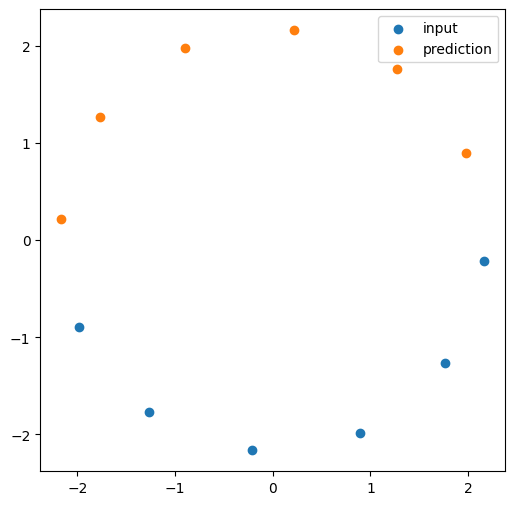

In [3]:
def plot_circle(input, prediction, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    plt.scatter(input[:, 0], input[:, 1], label="input")
    plt.scatter(prediction[:, 0], prediction[:, 1], label="prediction")
    plt.legend()
    
plot_circle(X_train[7], y_train[7])

# Train

In [4]:
cfg = Config(
    input_size=2, 
    attn_d_k=16,
    transformer_proj_dim=32,
    dropout=0.2,
    nlayers=2,
    is_self_attn=False,
    max_seq_len=TARGET_SEQ_LEN,
    nheads=2
)

def attn_factory(config: Config):
    return MultiheadAttention(
        input_size=config.input_size,
        d_k=config.attn_d_k,
        nheads=config.nheads,
        is_self_attn=config.is_self_attn,
        dropout=config.dropout
    )
    
decoder = TransformerDecoder(cfg, attn_factory)

ValueError: dropout probability has to be between 0 and 1, but got 2